In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Inspecting the columns of station table
inspector = inspect(engine)
station_columns = inspector.get_columns('Station')
for column in station_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Inspecting the columns of measurement table
measurement_columns = inspector.get_columns('Measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date is : {recent_date[0]}")

The most recent date is : 2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Convert date from string
final_date = dt.datetime.strptime(recent_date[0],"%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
one_year_prior = final_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_prior).all()
precipitation_data

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(precipitation_data)
data = data.set_index('date')
data = data.rename(columns ={'prcp':'precipitation'})

# Sort the dataframe by date
data = data.sort_values('date')
data.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


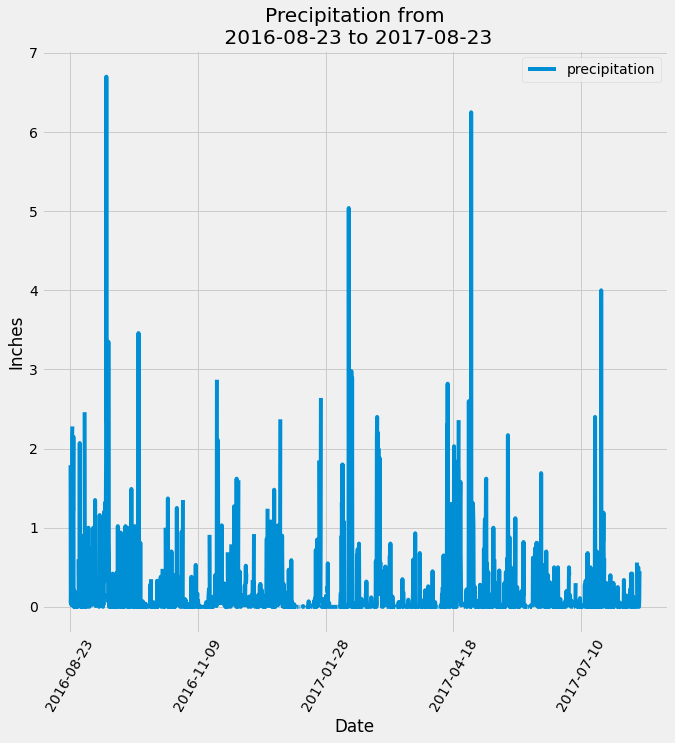

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot(rot=60, figsize=(10,10))
plt.title(f'Precipitation from\n {one_year_prior} to {final_date}')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [19]:
# Close Session
# session.close()